This code represents an attempt to replicate the DeepClean 1D convolutional neural network to reduce the signal-to-noise ratio in gravitational waves.

In [39]:
#Given pseudocode to grab the .h5 data file
import numpy as np
import h5py

## Y is the GW strain Data
## X is the auxillary data from other measurement channels

with h5py.File("data/deepclean-1251335314-4097.h5", "r") as f:
    X = []
    for channel, timeseries in f.items():
        if channel == "H1:GDS-CALIB_STRAIN":
            y = timeseries
        else:
            X.append(timeseries)
    X = np.stack(X)
    
    # then to construct inputs/outputs, you just
    # slice windows from these two timeseries
    window_length = 8
    sample_rate = 4096
    window_size = window_length * sample_rate

    # sample a batch of random windows
    batch_size = 32
    X_batch = [] 
    y_batch = []
    for i in range(batch_size):
        idx = np.random.randint(X.shape[-1] - window_size)
        X_batch.append(X[:, idx: idx + window_size])
        y_batch.append(y[idx: idx + window_size])
    X_batch = np.stack(X_batch)
    y_batch = np.stack(y_batch)
 
    # this method of generating batches is likely
    # to be very CPU-bound, and won't be any good
    # in any real training scenario. Luckily if you're
    # using torch and you can
    # pip install ml4gw
    # we've built a set of utilities for making
    # iterating through timeseries data easier
#     from ml4gw.dataloading import InMemoryDataset
#     dataloader = InMemoryDataset(
#         X=X,
#         y=y,
#         kernel_size=window_size,
#         batch_size=batch_size,
#         coincident=True,
#         shuffle=True,
#         device="cuda"
#     )

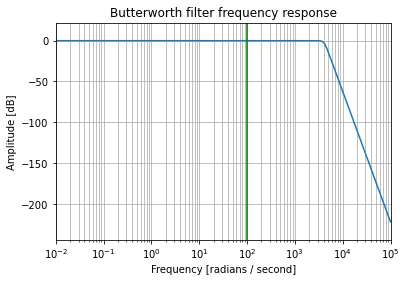

ValueError: x must be at least 1-D

In [62]:
#Preprocessing:
#Normalize the data
from scipy import signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

"""
Pre-processing data structure:

1. Anti-Imaging filter: Resample witness channels, Y, to the same frequency as the strain;
    - Currently, witness and strain are all sampled at 4096 Hz
2. 8th Order Butterworth: Aliasing filter to mitigate power from outside the witnessed noise frequencies;

3. StandardScalar: Unit variance, Zero mean;

4. Windowing: Divide data into smaller overlapping windows;
    - Segment Length: 8.00 Seconds;
    - 0.5 Hz => DFT of 2 Seconds;
    
5. Welches Method: 1 Second DFT overlap;

6. Training: Segment overlap [%] = 96.875

7. Testing: Segment overlap [%] = 50%
"""
strain_data = None
witness_data = None


# 2: Butterworth
N = 8 # order of butterworth filter
Wn = [0,4096] # passband [low end, high end]
filter_type = "bp"
fs = Wn[1]/2

b, a = signal.butter(N, Wn, filter_type, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()
butter_sos = signal.butter(N, Wn, filter_type, fs , output = 'sos')

# Apply butter_sos to data
strain_data = signal.sosfilt(butter_sos, strain_data)
witness_data = signal.sosfilt(butter_sos, witness_data)


# 3: Standard Scalar (Z-score)
scalar = StandardScalar()

strain_data = scalar.transform(strain_data)
witness_data = scalar.transform(witness_data)


# 4: Windowing
overlap_percent = 0.96875 #Percent
resolution = 0.5 #Hz
sample_rate = 4096 #LIGO sample rate
window_size = 8*sample_rate # 8 Seconds times 4096 samples per second
DFT_size = 2*sample_rate # 2 Seconds time 4096 sample rate


# 5: Welches Method
window_type = None
nperseg = window_size
noverlap = window_size*overlap_percent
nfft = DFT_size
strain_data = signal.welch(strain_data, fs, window_type, nperseg, noverlap, nfft)
witness_data = signal.welch(witness_data, fs, window_type, nperseg, noverlap, nfft)

In [ ]:
#Implement neural network.

#TOY MODEL COPY-PASTED FROM HW3
#MODEL FOR PART B, MODIFIED TO REPLICATE
#FIGURE 7 IN THE SOURCE WORK
from tensorflow.keras import layers

#Check input shape, given dataset is sampled at 4096Hz
model = keras.models.Sequential(name="attempt_1")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=5, strides=1, padding="same", activation="tanh", input_shape=(21, 8192)))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(, activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(, activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(, activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(, activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3, name="dropout_1"))
model.add(layers.Dense(1, activation="sigmoid", name="dense_1"))

model.build((None, 21, 8192))
model.summary()